# 초기 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.nn.modules.batchnorm import BatchNorm2d

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [3]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

device

device(type='cuda')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [5]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(), # tensor로 펴준다.
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
    torchvision.transforms.RandomHorizontalFlip(), 
])

## 데이터 로드 및 확인

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os

os.chdir("/content/drive/MyDrive/Data/Assignment/[0216]_CNN2")

In [8]:
# datasets

trainset = torchvision.datasets.CIFAR10(
    root = '/content/drive/MyDrive/Data/Assignment/[0216]_CNN2',        # 데이터 저장 위치
    train = True,                                                       # True: train set, False: test set
    download = False,                                                    # 다운로드 여부, (이미 다운받았으면 False로 지정)
    transform = train_transform
    
)

testset = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Data/Assignment/[0216]_CNN2',
    train = False,
    download = False,
    transform = CIFAR_transform

)

In [9]:
# DataLoader

# batch-size = 4

train_loader =  DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)
test_loader =  DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)

In [10]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

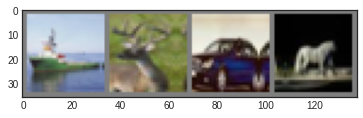

ship	 deer	 car	 horse	


In [11]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

# Ver.1

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 4 / Maxpool : 3 / fc : 2
* Bn : o / Dropout : o / softmax : x / residual block : x / weight_decay = 1e-4

In [ ]:
class Net_ver1(nn.Module) :

    def __init__(self) :

        super(Net_ver1, self).__init__()

        # Maxpool : 32 -> 16

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , stride = 1 , padding = 1)
        # (16 - 3 + 2)/1 + 1 = 16
        # 4 * 64 * 16 * 16 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , stride = 1 , padding = 1)
        # (16 - 3 + 2)/1 + 1 = 16
        # 4 * 64 * 16 * 16

        self.bn2 = BatchNorm2d(64)

        # Maxpool : 16 -> 8

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 128 , kernel_size = 3 , stride = 1 , padding = 1)
        # (8 - 3 + 2)/1 + 1 = 8
        # 4 * 128 * 16 * 16 

        self.bn3 = BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels = 128 , out_channels = 128 , kernel_size = 3 , stride = 1 , padding = 1)
        # (8 - 3 + 2)/1 + 1 = 8
        # 4 * 128 * 8 * 8

        self.bn4 = BatchNorm2d(128)

        # Maxpool : 8 -> 4

        self.fc1 = nn.Linear(in_features = 2048 , out_features = 4 , bias = True)

        self.fc2 = nn.Linear(in_features = 4 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      maxpool1_result = F.max_pool2d(x , (2,2))

      conv1_result = F.relu(self.bn1(self.conv1(maxpool1_result)))

      conv1_result = self.dropout(conv1_result)
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      conv2_result = self.dropout(conv2_result)

      maxpool2_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool2_result)))

      conv3_result = self.dropout(conv3_result)
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      conv4_result = self.dropout(conv4_result)

      maxpool3_result = F.max_pool2d(conv4_result, (2,2))

      flatten_result = maxpool3_result.view(maxpool3_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = self.fc2(fc1_result)

      return fc2_result

In [ ]:
myNet = Net_ver1().to(device) # gpu에 모델 저장

myNet

Net_ver1(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 16, 16]           1,792
       BatchNorm2d-2            [4, 64, 16, 16]             128
           Dropout-3            [4, 64, 16, 16]               0
            Conv2d-4            [4, 64, 16, 16]          36,928
       BatchNorm2d-5            [4, 64, 16, 16]             128
           Dropout-6            [4, 64, 16, 16]               0
            Conv2d-7             [4, 128, 8, 8]          73,856
       BatchNorm2d-8             [4, 128, 8, 8]             256
           Dropout-9             [4, 128, 8, 8]               0
           Conv2d-10             [4, 128, 8, 8]         147,584
      BatchNorm2d-11             [4, 128, 8, 8]             256
          Dropout-12             [4, 128, 8, 8]               0
           Linear-13                     [4, 4]           8,196
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myNet.parameters(), lr = 0.001, betas = (0.9 , 0.999) , weight_decay = 1e-4)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.3251344130039215
Epoch: 1, Batch: 4000, Loss: 2.304070479273796
Epoch: 1, Batch: 6000, Loss: 2.303667744755745
Epoch: 1, Batch: 8000, Loss: 2.302923220038414
Epoch: 1, Batch: 10000, Loss: 2.302979740977287
Epoch: 1, Batch: 12000, Loss: 2.3028998963832854
Epoch: 2, Batch: 2000, Loss: 2.30289160656929
Epoch: 2, Batch: 4000, Loss: 2.3030295981168747
Epoch: 2, Batch: 6000, Loss: 2.3029932738542556
Epoch: 2, Batch: 8000, Loss: 2.303034716963768
Epoch: 2, Batch: 10000, Loss: 2.303251479387283
Epoch: 2, Batch: 12000, Loss: 2.3027102971076965
Epoch: 3, Batch: 2000, Loss: 2.303073404788971
Epoch: 3, Batch: 4000, Loss: 2.302987951874733
Epoch: 3, Batch: 6000, Loss: 2.303011180281639
Epoch: 3, Batch: 8000, Loss: 2.303100614309311
Epoch: 3, Batch: 10000, Loss: 2.3032792328596114
Epoch: 3, Batch: 12000, Loss: 2.3031098141670228
Epoch: 4, Batch: 2000, Loss: 2.302812507867813
Epoch: 4, Batch: 4000, Loss: 2.303166847348213
Epoch: 4, Batch: 6000, Loss: 2.3028975291252136


## 모델의 저장 및 로드

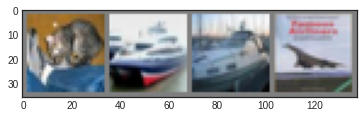

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver1().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

10.0


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 0.0%
Accuracy of car: 0.0%
Accuracy of bird: 0.0%
Accuracy of cat: 0.0%
Accuracy of deer: 0.0%
Accuracy of dog: 100.0%
Accuracy of frog: 0.0%
Accuracy of horse: 0.0%
Accuracy of ship: 0.0%
Accuracy of truck: 0.0%


# Ver.2

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : x / weight_decay = 1e-4

In [ ]:
class Net_ver2(nn.Module) :

    def __init__(self) :

        super(Net_ver2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 128 , kernel_size = 5)
        # (16 - 5 + 0)/1 + 12 = 12
        # 4 * 128 * 12 * 12 

        self.bn3 = BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels = 128 , out_channels = 128 , kernel_size = 3 , padding = 1)
        # (12 - 3 + 2)/1 + 1 = 12
        # 4 * 128 * 12 * 12

        self.bn4 = BatchNorm2d(128)

        self.conv5 = nn.Conv2d(in_channels = 128 , out_channels = 32 , kernel_size = 3)
        # (12 - 3 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 1000 , bias = True)

        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100 , bias = True)

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      maxpool2_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool2_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      conv5_result = F.relu(self.bn5(self.conv5(conv4_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      flatten_result = conv6_result.view(conv6_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.fc3(fc2_result)

      return fc3_result

In [ ]:
myNet = Net_ver2().to(device) # gpu에 모델 저장

myNet

Net_ver2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_fe

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5           [4, 128, 12, 12]         204,928
       BatchNorm2d-6           [4, 128, 12, 12]             256
            Conv2d-7           [4, 128, 12, 12]         147,584
       BatchNorm2d-8           [4, 128, 12, 12]             256
            Conv2d-9            [4, 32, 10, 10]          36,896
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                  [4, 1000]       3,201,000
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(myNet.parameters(), lr = 0.001, betas = (0.9 , 0.999))

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.1632027525901796
Epoch: 1, Batch: 4000, Loss: 1.994809383958578
Epoch: 1, Batch: 6000, Loss: 1.8529254999756812
Epoch: 1, Batch: 8000, Loss: 1.7556317272782325
Epoch: 1, Batch: 10000, Loss: 1.6512677833437919
Epoch: 1, Batch: 12000, Loss: 1.582318836644292
Epoch: 2, Batch: 2000, Loss: 1.4835304521247745
Epoch: 2, Batch: 4000, Loss: 1.416262681826949
Epoch: 2, Batch: 6000, Loss: 1.3959908831715584
Epoch: 2, Batch: 8000, Loss: 1.356540251635015
Epoch: 2, Batch: 10000, Loss: 1.3393649891801178
Epoch: 2, Batch: 12000, Loss: 1.252361459977925
Epoch: 3, Batch: 2000, Loss: 1.2349499998223037
Epoch: 3, Batch: 4000, Loss: 1.2040156838875264
Epoch: 3, Batch: 6000, Loss: 1.1498090527472087
Epoch: 3, Batch: 8000, Loss: 1.157265012634918
Epoch: 3, Batch: 10000, Loss: 1.1279787128996104
Epoch: 3, Batch: 12000, Loss: 1.1324906927417033
Epoch: 4, Batch: 2000, Loss: 1.0659916550181807
Epoch: 4, Batch: 4000, Loss: 1.0590921263401396
Epoch: 4, Batch: 6000, Loss: 1.033144892

## 모델의 저장 및 로드

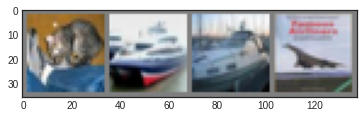

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver2().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

72.44


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 69.3%
Accuracy of car: 90.5%
Accuracy of bird: 54.0%
Accuracy of cat: 62.4%
Accuracy of deer: 68.9%
Accuracy of dog: 68.6%
Accuracy of frog: 77.3%
Accuracy of horse: 74.5%
Accuracy of ship: 80.9%
Accuracy of truck: 79.2%


# Ver.3

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : x / weight_decay = 1e-4
* 적은 channel에서 kernel_size 늘리기

In [ ]:
class Net_ver3(nn.Module) :

    def __init__(self) :

        super(Net_ver3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 128 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 128 * 14 * 14 

        self.bn3 = BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels = 128 , out_channels = 128 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 128 * 14 * 14

        self.bn4 = BatchNorm2d(128)

        self.conv5 = nn.Conv2d(in_channels = 128 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 1000 , bias = True)

        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100 , bias = True)

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      maxpool_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      conv5_result = F.relu(self.bn5(self.conv5(conv4_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      flatten_result = conv6_result.view(conv6_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.fc3(fc2_result)

      return fc3_result

In [ ]:
myNet = Net_ver3().to(device) # gpu에 모델 저장

myNet

Net_ver3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_fe

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5           [4, 128, 14, 14]          73,856
       BatchNorm2d-6           [4, 128, 14, 14]             256
            Conv2d-7           [4, 128, 14, 14]         147,584
       BatchNorm2d-8           [4, 128, 14, 14]             256
            Conv2d-9            [4, 32, 10, 10]         102,432
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                  [4, 1000]       3,201,000
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(myNet.parameters(), lr = 0.001, betas = (0.9 , 0.999))

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.1706803357601165
Epoch: 1, Batch: 4000, Loss: 1.9981531541347504
Epoch: 1, Batch: 6000, Loss: 1.8765287768244743
Epoch: 1, Batch: 8000, Loss: 1.7524610067605972
Epoch: 1, Batch: 10000, Loss: 1.6516341997981072
Epoch: 1, Batch: 12000, Loss: 1.5456059071794153
Epoch: 2, Batch: 2000, Loss: 1.4386527872532606
Epoch: 2, Batch: 4000, Loss: 1.3928730303123593
Epoch: 2, Batch: 6000, Loss: 1.3383918305784464
Epoch: 2, Batch: 8000, Loss: 1.27305208180286
Epoch: 2, Batch: 10000, Loss: 1.2563430310525001
Epoch: 2, Batch: 12000, Loss: 1.2188548376676627
Epoch: 3, Batch: 2000, Loss: 1.1615095128035173
Epoch: 3, Batch: 4000, Loss: 1.144502085071057
Epoch: 3, Batch: 6000, Loss: 1.110459331211401
Epoch: 3, Batch: 8000, Loss: 1.0881343843350186
Epoch: 3, Batch: 10000, Loss: 1.0804098345553503
Epoch: 3, Batch: 12000, Loss: 1.1053885897316504
Epoch: 4, Batch: 2000, Loss: 1.008929927314748
Epoch: 4, Batch: 4000, Loss: 1.0006521223420277
Epoch: 4, Batch: 6000, Loss: 0.98920650

## 모델의 저장 및 로드

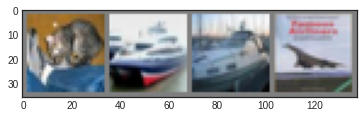

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver3().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

74.37


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 76.4%
Accuracy of car: 86.5%
Accuracy of bird: 64.6%
Accuracy of cat: 57.3%
Accuracy of deer: 67.8%
Accuracy of dog: 59.7%
Accuracy of frog: 80.1%
Accuracy of horse: 82.1%
Accuracy of ship: 84.6%
Accuracy of truck: 85.2%


# Ver.4

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : x / weight_decay = x
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [ ]:
class Net_ver4(nn.Module) :

    def __init__(self) :

        super(Net_ver4, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 1000 , bias = True)

        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100 , bias = True)

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      maxpool_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      conv5_result = F.relu(self.bn5(self.conv5(conv4_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      flatten_result = conv6_result.view(conv6_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.fc3(fc2_result)

      return fc3_result

In [ ]:
myNet = Net_ver4().to(device) # gpu에 모델 저장

myNet

Net_ver4(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                  [4, 1000]       3,201,000
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.9566352524757384
Epoch: 1, Batch: 4000, Loss: 1.655214336976409
Epoch: 1, Batch: 6000, Loss: 1.5108708229884504
Epoch: 1, Batch: 8000, Loss: 1.3931001293770968
Epoch: 1, Batch: 10000, Loss: 1.2922702222391964
Epoch: 1, Batch: 12000, Loss: 1.2462843848317862
Epoch: 2, Batch: 2000, Loss: 1.1425050496160984
Epoch: 2, Batch: 4000, Loss: 1.0674276774609461
Epoch: 2, Batch: 6000, Loss: 1.069856735044159
Epoch: 2, Batch: 8000, Loss: 1.0256913414262234
Epoch: 2, Batch: 10000, Loss: 0.990768116241321
Epoch: 2, Batch: 12000, Loss: 0.9814404961224645
Epoch: 3, Batch: 2000, Loss: 0.8884991091513075
Epoch: 3, Batch: 4000, Loss: 0.8731804507587804
Epoch: 3, Batch: 6000, Loss: 0.8587156172168907
Epoch: 3, Batch: 8000, Loss: 0.8406674905314576
Epoch: 3, Batch: 10000, Loss: 0.8223169128870359
Epoch: 3, Batch: 12000, Loss: 0.8266611558729783
Epoch: 4, Batch: 2000, Loss: 0.7232518164641588
Epoch: 4, Batch: 4000, Loss: 0.7189054467920214
Epoch: 4, Batch: 6000, Loss: 0.716108

## 모델의 저장 및 로드

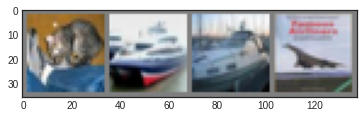

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver4().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

78.5


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 80.6%
Accuracy of car: 85.9%
Accuracy of bird: 71.3%
Accuracy of cat: 60.5%
Accuracy of deer: 70.5%
Accuracy of dog: 70.0%
Accuracy of frog: 81.5%
Accuracy of horse: 83.9%
Accuracy of ship: 88.8%
Accuracy of truck: 88.3%


# Ver.5

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : o / residual block : x / weight_decay = 1e-4
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SG

In [ ]:
class Net_ver5(nn.Module) :

    def __init__(self) :

        super(Net_ver5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 1000 , bias = True)

        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100 , bias = True)

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      maxpool_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      conv5_result = F.relu(self.bn5(self.conv5(conv4_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      flatten_result = conv6_result.view(conv6_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.fc3(fc2_result)

      fc3_result = F.log_softmax(fc3_result , dim = 1)

      return fc3_result

In [ ]:
myNet = Net_ver5().to(device) # gpu에 모델 저장

myNet

Net_ver5(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                  [4, 1000]       3,201,000
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9 , weight_decay = 1e-4)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.9581117537021637
Epoch: 1, Batch: 4000, Loss: 1.6792409437596798
Epoch: 1, Batch: 6000, Loss: 1.503730505168438
Epoch: 1, Batch: 8000, Loss: 1.3937569820582867
Epoch: 1, Batch: 10000, Loss: 1.3155838512256741
Epoch: 1, Batch: 12000, Loss: 1.2411746731698512
Epoch: 2, Batch: 2000, Loss: 1.1321312795914709
Epoch: 2, Batch: 4000, Loss: 1.1111937330849468
Epoch: 2, Batch: 6000, Loss: 1.0655598731478677
Epoch: 2, Batch: 8000, Loss: 1.0110915535581297
Epoch: 2, Batch: 10000, Loss: 0.9967887241495773
Epoch: 2, Batch: 12000, Loss: 0.9641598325194791
Epoch: 3, Batch: 2000, Loss: 0.8876232415589038
Epoch: 3, Batch: 4000, Loss: 0.8751904676011764
Epoch: 3, Batch: 6000, Loss: 0.876407116970222
Epoch: 3, Batch: 8000, Loss: 0.8506653708745725
Epoch: 3, Batch: 10000, Loss: 0.8473138245928566
Epoch: 3, Batch: 12000, Loss: 0.7935384594802745
Epoch: 4, Batch: 2000, Loss: 0.747564809711068
Epoch: 4, Batch: 4000, Loss: 0.7297395807395224
Epoch: 4, Batch: 6000, Loss: 0.720349

## 모델의 저장 및 로드

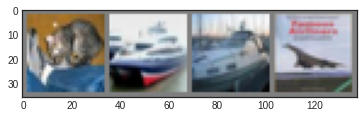

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver5().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

78.05


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 81.5%
Accuracy of car: 90.4%
Accuracy of bird: 63.7%
Accuracy of cat: 60.4%
Accuracy of deer: 67.3%
Accuracy of dog: 78.4%
Accuracy of frog: 81.7%
Accuracy of horse: 82.2%
Accuracy of ship: 87.6%
Accuracy of truck: 84.9%


# Ver.6

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : o / weight_decay = 1e-4
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [ ]:
class Net_ver6(nn.Module) :

    def __init__(self) :

        super(Net_ver6, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Residual block

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        # Residual block

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        # Residual block

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 1000 , bias = True)

        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100 , bias = True)

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = self.bn2(self.conv2(conv1_result))

      residual1_result = F.relu(conv1_result + conv2_result)

      maxpool_result = F.max_pool2d(residual1_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      residual2_result = F.relu(conv3_result + conv4_result)

      conv5_result = F.relu(self.bn5(self.conv5(residual2_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      residual3_result = F.relu(conv5_result + conv6_result)

      flatten_result = residual3_result.view(residual3_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.fc3(fc2_result)

      return fc3_result

In [ ]:
myNet = Net_ver6().to(device) # gpu에 모델 저장

myNet

Net_ver6(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                  [4, 1000]       3,201,000
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9 , weight_decay = 1e-4)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.942907780110836
Epoch: 1, Batch: 4000, Loss: 1.673029744952917
Epoch: 1, Batch: 6000, Loss: 1.5055958840101957
Epoch: 1, Batch: 8000, Loss: 1.4199003972187638
Epoch: 1, Batch: 10000, Loss: 1.352302557464689
Epoch: 1, Batch: 12000, Loss: 1.2675791825409979
Epoch: 2, Batch: 2000, Loss: 1.16543094679527
Epoch: 2, Batch: 4000, Loss: 1.1378833119980991
Epoch: 2, Batch: 6000, Loss: 1.0775966204050929
Epoch: 2, Batch: 8000, Loss: 1.0103301220531575
Epoch: 2, Batch: 10000, Loss: 1.0246881716814824
Epoch: 2, Batch: 12000, Loss: 0.9834927600090159
Epoch: 3, Batch: 2000, Loss: 0.9193018690880854
Epoch: 3, Batch: 4000, Loss: 0.8825935039226898
Epoch: 3, Batch: 6000, Loss: 0.8691042286753654
Epoch: 3, Batch: 8000, Loss: 0.8497410306301899
Epoch: 3, Batch: 10000, Loss: 0.8586532199727371
Epoch: 3, Batch: 12000, Loss: 0.8078221541477832
Epoch: 4, Batch: 2000, Loss: 0.7451221189118223
Epoch: 4, Batch: 4000, Loss: 0.7416395945327822
Epoch: 4, Batch: 6000, Loss: 0.72885924

## 모델의 저장 및 로드

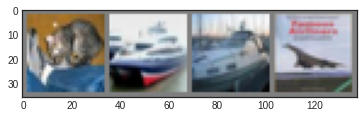

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver6().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

76.9


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 82.3%
Accuracy of car: 86.8%
Accuracy of bird: 68.3%
Accuracy of cat: 53.5%
Accuracy of deer: 73.2%
Accuracy of dog: 70.1%
Accuracy of frog: 83.0%
Accuracy of horse: 82.8%
Accuracy of ship: 87.2%
Accuracy of truck: 84.2%


# Ver.7 -> 폐기

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 2
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : o / weight_decay = 1e-4
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD
* fc layer initialization

In [ ]:
class Net_ver7(nn.Module) :

    def __init__(self) :

        super(Net_ver7, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Residual block

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        # Residual block

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        # Residual block

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 1000 , bias = True)
        nn.init.xavier_uniform_(self.fc1.weight , gain = nn.init.calculate_gain('relu'))

        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100 , bias = True)
        nn.init.xavier_uniform_(self.fc2.weight , gain=nn.init.calculate_gain('relu'))

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)
        nn.init.xavier_uniform_(self.fc3.weight , gain=nn.init.calculate_gain('relu'))

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = self.bn2(self.conv2(conv1_result))

      residual1_result = F.relu(conv1_result + conv2_result)

      maxpool2_result = F.max_pool2d(residual1_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool2_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      residual2_result = F.relu(conv3_result + conv4_result)

      conv5_result = F.relu(self.bn5(self.conv5(residual2_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      residual3_result = F.relu(conv5_result + conv6_result)

      flatten_result = residual3_result.view(residual3_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.fc3(fc2_result)

      return fc3_result

In [ ]:
myNet = Net_ver7().to(device) # gpu에 모델 저장

myNet

Net_ver7(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                  [4, 1000]       3,201,000
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9 , weight_decay = 1e-4)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.3546259357333184
Epoch: 1, Batch: 4000, Loss: 2.3036204508543014
Epoch: 1, Batch: 6000, Loss: 2.3030341824293137
Epoch: 1, Batch: 8000, Loss: 2.303338215112686
Epoch: 1, Batch: 10000, Loss: 2.3033877230882647
Epoch: 1, Batch: 12000, Loss: 2.3029897735118867
Epoch: 2, Batch: 2000, Loss: 2.3031276919841766


KeyboardInterrupt: ignored

## 모델의 저장 및 로드

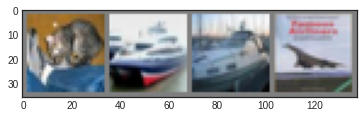

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver7().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

76.65


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 80.6%
Accuracy of car: 85.9%
Accuracy of bird: 71.3%
Accuracy of cat: 60.5%
Accuracy of deer: 70.5%
Accuracy of dog: 70.0%
Accuracy of frog: 81.5%
Accuracy of horse: 83.9%
Accuracy of ship: 88.8%
Accuracy of truck: 88.3%


# Ver.8

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 1
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : o / weight_decay = 1e-4
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD
* fc layer initialization
* GAP 사용

In [ ]:
class Net_ver8(nn.Module) :

    def __init__(self) :

        super(Net_ver8, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Residual block

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        # Residual block

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        # Residual block

        self.avg_pool = nn.AvgPool2d(10)

        self.fc1 = nn.Linear(in_features = 32 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = self.bn2(self.conv2(conv1_result))

      residual1_result = F.relu(conv1_result + conv2_result)

      maxpool2_result = F.max_pool2d(residual1_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool2_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      residual2_result = F.relu(conv3_result + conv4_result)

      conv5_result = F.relu(self.bn5(self.conv5(residual2_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      residual3_result = F.relu(conv5_result + conv6_result)

      avgpool_result = self.avg_pool(residual3_result)

      flatten_result = avgpool_result.view(avgpool_result.size(0), -1)

      fc1_result = self.fc1(flatten_result)

      return fc1_result

In [ ]:
myNet = Net_ver8().to(device) # gpu에 모델 저장

myNet

Net_ver8(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AvgPool2d(ker

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
        AvgPool2d-13              [4, 32, 1, 1]               0
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9 , weight_decay = 1e-4)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.899386409431696
Epoch: 1, Batch: 4000, Loss: 1.672538291156292
Epoch: 1, Batch: 6000, Loss: 1.5471395189613104
Epoch: 1, Batch: 8000, Loss: 1.4616038783937693
Epoch: 1, Batch: 10000, Loss: 1.3842043532282113
Epoch: 1, Batch: 12000, Loss: 1.3378901871964335
Epoch: 2, Batch: 2000, Loss: 1.249588159583509
Epoch: 2, Batch: 4000, Loss: 1.1995718189142643
Epoch: 2, Batch: 6000, Loss: 1.1664309323728084
Epoch: 2, Batch: 8000, Loss: 1.1250857016071678
Epoch: 2, Batch: 10000, Loss: 1.1120734451040626
Epoch: 2, Batch: 12000, Loss: 1.0874789627492427
Epoch: 3, Batch: 2000, Loss: 1.0344685840420424
Epoch: 3, Batch: 4000, Loss: 1.0205136678721756
Epoch: 3, Batch: 6000, Loss: 0.9994811093490571
Epoch: 3, Batch: 8000, Loss: 0.9671370935048909
Epoch: 3, Batch: 10000, Loss: 0.9546254921443761
Epoch: 3, Batch: 12000, Loss: 0.9356552965790034
Epoch: 4, Batch: 2000, Loss: 0.9204458808638155
Epoch: 4, Batch: 4000, Loss: 0.8933276412468404
Epoch: 4, Batch: 6000, Loss: 0.883071

## 모델의 저장 및 로드

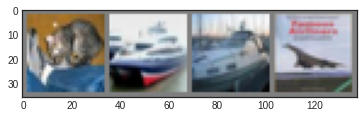

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver8().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

76.79


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 74.7%
Accuracy of car: 86.7%
Accuracy of bird: 75.1%
Accuracy of cat: 67.8%
Accuracy of deer: 74.2%
Accuracy of dog: 59.1%
Accuracy of frog: 77.3%
Accuracy of horse: 82.8%
Accuracy of ship: 84.7%
Accuracy of truck: 85.5%


# Ver.9

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 2
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : o / weight_decay = 1e-4
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD
* fc layer initialization
* GAP 사용 but fc layer 2개

In [ ]:
class Net_ver9(nn.Module) :

    def __init__(self) :

        super(Net_ver9, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Residual block

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        # Residual block

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        # Residual block

        self.avg_pool = nn.AvgPool2d(10)

        self.fc1 = nn.Linear(in_features = 32 , out_features = 20 , bias = True)

        self.fc2 = nn.Linear(in_features = 20 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = self.bn2(self.conv2(conv1_result))

      residual1_result = F.relu(conv1_result + conv2_result)

      maxpool2_result = F.max_pool2d(residual1_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool2_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      residual2_result = F.relu(conv3_result + conv4_result)

      conv5_result = F.relu(self.bn5(self.conv5(residual2_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      residual3_result = F.relu(conv5_result + conv6_result)

      avgpool_result = self.avg_pool(residual3_result)

      flatten_result = avgpool_result.view(avgpool_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = self.fc2(fc1_result)

      return fc2_result

In [ ]:
myNet = Net_ver9().to(device) # gpu에 모델 저장

myNet

Net_ver9(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AvgPool2d(ker

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
        AvgPool2d-13              [4, 32, 1, 1]               0
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9 , weight_decay = 1e-4)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.00143345490098
Epoch: 1, Batch: 4000, Loss: 1.7921938486099243
Epoch: 1, Batch: 6000, Loss: 1.6557194565534592
Epoch: 1, Batch: 8000, Loss: 1.5542778753191233
Epoch: 1, Batch: 10000, Loss: 1.462300921857357
Epoch: 1, Batch: 12000, Loss: 1.3811618528664111
Epoch: 2, Batch: 2000, Loss: 1.2933545480519533
Epoch: 2, Batch: 4000, Loss: 1.2673239648416639
Epoch: 2, Batch: 6000, Loss: 1.2256675551459193
Epoch: 2, Batch: 8000, Loss: 1.190793762575835
Epoch: 2, Batch: 10000, Loss: 1.2051373735666275
Epoch: 2, Batch: 12000, Loss: 1.1212844219207763
Epoch: 3, Batch: 2000, Loss: 1.0860123445298522
Epoch: 3, Batch: 4000, Loss: 1.0629034025073052
Epoch: 3, Batch: 6000, Loss: 1.0779830690659582
Epoch: 3, Batch: 8000, Loss: 1.0554292164146901
Epoch: 3, Batch: 10000, Loss: 1.0101343305762858
Epoch: 3, Batch: 12000, Loss: 0.9956157689793035
Epoch: 4, Batch: 2000, Loss: 0.9553164584189653
Epoch: 4, Batch: 4000, Loss: 0.9380506889345125
Epoch: 4, Batch: 6000, Loss: 0.9461839

## 모델의 저장 및 로드

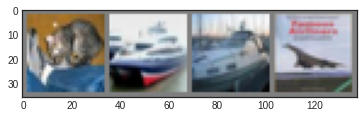

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver9().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f03cf658dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f03cf658dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

76.75


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 76.8%
Accuracy of car: 90.0%
Accuracy of bird: 61.3%
Accuracy of cat: 63.5%
Accuracy of deer: 74.9%
Accuracy of dog: 68.5%
Accuracy of frog: 79.8%
Accuracy of horse: 84.5%
Accuracy of ship: 82.3%
Accuracy of truck: 85.9%


# Ver.10 -> ver.6 개조 (+ conv layer)

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : o / weight_decay = 1e-4
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [ ]:
class Net_ver10(nn.Module) :

    def __init__(self) :

        super(Net_ver10, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Residual block

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        # Residual block

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        # Residual block

        self.conv7 = nn.Conv2d(in_channels = 32 , out_channels = 16 , kernel_size = 5)
        # (10 - 5 + 0)/1 + 1 = 6
        # 4 * 16 * 6 * 6 

        self.bn7 = BatchNorm2d(16)

        self.conv8 = nn.Conv2d(in_channels = 16 , out_channels = 16 , kernel_size = 3 , padding = 1)
        # (6 - 3 + 2)/1 + 1 = 6
        # 4 * 16 * 6 * 6

        self.bn8 = BatchNorm2d(16)

        self.fc1 = nn.Linear(in_features = 576 , out_features = 200 , bias = True)

        self.fc2 = nn.Linear(in_features = 200 , out_features = 100 , bias = True)

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = self.bn2(self.conv2(conv1_result))

      residual1_result = F.relu(conv1_result + conv2_result)

      maxpool_result = F.max_pool2d(residual1_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      residual2_result = F.relu(conv3_result + conv4_result)

      conv5_result = F.relu(self.bn5(self.conv5(residual2_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      residual3_result = F.relu(conv5_result + conv6_result)

      conv7_result = F.relu(self.bn7(self.conv7(residual3_result)))

      conv8_result = F.relu(self.bn8(self.conv8(conv7_result)))

      residual4_result = F.relu(conv7_result + conv8_result)

      flatten_result = residual4_result.view(residual4_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.fc3(fc2_result)

      return fc3_result

In [ ]:
myNet = Net_ver10().to(device) # gpu에 모델 저장

myNet

Net_ver10(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(32, 16, 

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Conv2d-13              [4, 16, 6, 6]          12,816
      BatchNorm2d-14              [4, 1

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9 , weight_decay = 1e-4)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.025797983765602
Epoch: 1, Batch: 4000, Loss: 1.8018395239114762
Epoch: 1, Batch: 6000, Loss: 1.6826499914079904
Epoch: 1, Batch: 8000, Loss: 1.554113515779376
Epoch: 1, Batch: 10000, Loss: 1.4769827233701944
Epoch: 1, Batch: 12000, Loss: 1.3959811316505075
Epoch: 2, Batch: 2000, Loss: 1.3345365892127157
Epoch: 2, Batch: 4000, Loss: 1.281816969320178
Epoch: 2, Batch: 6000, Loss: 1.2302073872685433
Epoch: 2, Batch: 8000, Loss: 1.1915916587226092
Epoch: 2, Batch: 10000, Loss: 1.2018762811943888
Epoch: 2, Batch: 12000, Loss: 1.1710585509836673
Epoch: 3, Batch: 2000, Loss: 1.0956455295684282
Epoch: 3, Batch: 4000, Loss: 1.0616504257135093
Epoch: 3, Batch: 6000, Loss: 1.051679048858583
Epoch: 3, Batch: 8000, Loss: 1.0568833103701472
Epoch: 3, Batch: 10000, Loss: 1.0471366697344928
Epoch: 3, Batch: 12000, Loss: 1.0020401925556361
Epoch: 4, Batch: 2000, Loss: 0.9552624162132852
Epoch: 4, Batch: 4000, Loss: 0.935488713641651
Epoch: 4, Batch: 6000, Loss: 0.94081746

## 모델의 저장 및 로드

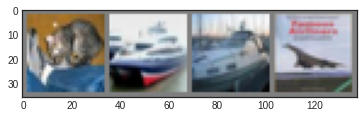

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver10().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

74.91


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 79.0%
Accuracy of car: 90.3%
Accuracy of bird: 62.9%
Accuracy of cat: 62.2%
Accuracy of deer: 64.9%
Accuracy of dog: 64.0%
Accuracy of frog: 79.7%
Accuracy of horse: 73.5%
Accuracy of ship: 85.0%
Accuracy of truck: 85.9%


# Ver.11 -> ver.6 개조 (+ fc layer)

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : o / weight_decay = 1e-4
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [ ]:
class Net_ver11(nn.Module) :

    def __init__(self) :

        super(Net_ver11, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Residual block

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        # Residual block

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 800 , bias = True)

        self.fc2 = nn.Linear(in_features = 800 , out_features = 200 , bias = True)

        self.fc3 = nn.Linear(in_features = 200 , out_features = 100 , bias = True)

        self.fc4 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = self.bn2(self.conv2(conv1_result))

      residual1_result = F.relu(conv1_result + conv2_result)

      maxpool_result = F.max_pool2d(residual1_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      residual2_result = F.relu(conv3_result + conv4_result)

      conv5_result = F.relu(self.bn5(self.conv5(residual2_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      residual3_result = F.relu(conv5_result + conv6_result)

      flatten_result = residual3_result.view(residual3_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc3_result = F.relu(self.fc3(fc2_result))

      fc3_result = self.dropout(fc2_result)

      fc4_result = self.fc3(fc3_result)

      return fc4_result

In [ ]:
myNet = Net_ver11().to(device) # gpu에 모델 저장

myNet

Net_ver11(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_feature

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 100])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                   [4, 800]       2,560,800
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9 , weight_decay = 1e-4)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.081607280999422
Epoch: 1, Batch: 4000, Loss: 1.7197175320982934
Epoch: 1, Batch: 6000, Loss: 1.5650069815814496
Epoch: 1, Batch: 8000, Loss: 1.4045990733727813
Epoch: 1, Batch: 10000, Loss: 1.3151843305677176
Epoch: 1, Batch: 12000, Loss: 1.2496998614149635
Epoch: 2, Batch: 2000, Loss: 1.1248477702774107
Epoch: 2, Batch: 4000, Loss: 1.088189525099937
Epoch: 2, Batch: 6000, Loss: 1.0489800164478364
Epoch: 2, Batch: 8000, Loss: 1.017100508772768
Epoch: 2, Batch: 10000, Loss: 1.0032561465720646
Epoch: 2, Batch: 12000, Loss: 0.9444339307015762
Epoch: 3, Batch: 2000, Loss: 0.8667164865030209
Epoch: 3, Batch: 4000, Loss: 0.84525956587377
Epoch: 3, Batch: 6000, Loss: 0.8209593201762764
Epoch: 3, Batch: 8000, Loss: 0.844480392998783
Epoch: 3, Batch: 10000, Loss: 0.833984053550521
Epoch: 3, Batch: 12000, Loss: 0.79746265050472
Epoch: 4, Batch: 2000, Loss: 0.693692553670844
Epoch: 4, Batch: 4000, Loss: 0.7106809856243199
Epoch: 4, Batch: 6000, Loss: 0.7074029692055

## 모델의 저장 및 로드

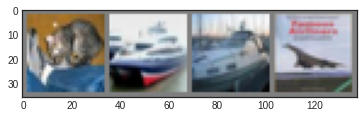

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver11().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

77.17


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 78.3%
Accuracy of car: 83.0%
Accuracy of bird: 63.7%
Accuracy of cat: 61.9%
Accuracy of deer: 76.5%
Accuracy of dog: 75.5%
Accuracy of frog: 78.2%
Accuracy of horse: 79.1%
Accuracy of ship: 88.3%
Accuracy of truck: 88.2%


# Ver.12 -> ver.6 개조 (+ fc layer / epoch 늘리기 10 -> 20)

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : o / weight_decay = 1e-4
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [ ]:
class Net_ver12(nn.Module) :

    def __init__(self) :

        super(Net_ver12, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Residual block

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        # Residual block

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 800 , bias = True)

        self.fc2 = nn.Linear(in_features = 800 , out_features = 200 , bias = True)

        self.fc3 = nn.Linear(in_features = 200 , out_features = 100 , bias = True)

        self.fc4 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = self.bn2(self.conv2(conv1_result))

      residual1_result = F.relu(conv1_result + conv2_result)

      maxpool_result = F.max_pool2d(residual1_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      residual2_result = F.relu(conv3_result + conv4_result)

      conv5_result = F.relu(self.bn5(self.conv5(residual2_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      residual3_result = F.relu(conv5_result + conv6_result)

      flatten_result = residual3_result.view(residual3_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc3_result = F.relu(self.fc3(fc2_result))

      fc3_result = self.dropout(fc2_result)

      fc4_result = self.fc3(fc3_result)

      return fc4_result

In [ ]:
myNet = Net_ver12().to(device) # gpu에 모델 저장

myNet

Net_ver12(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_feature

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 100])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                   [4, 800]       2,560,800
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9 , weight_decay = 1e-4)

## 모델 학습

In [ ]:
# epochs = 20

for epoch in range(20) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.066708651483059
Epoch: 1, Batch: 4000, Loss: 1.7096356876939536
Epoch: 1, Batch: 6000, Loss: 1.5286986845992505
Epoch: 1, Batch: 8000, Loss: 1.415933381870389
Epoch: 1, Batch: 10000, Loss: 1.3087376576215028
Epoch: 1, Batch: 12000, Loss: 1.2341335164625198
Epoch: 2, Batch: 2000, Loss: 1.1332761068092658
Epoch: 2, Batch: 4000, Loss: 1.0968463746383785
Epoch: 2, Batch: 6000, Loss: 1.053086056323722
Epoch: 2, Batch: 8000, Loss: 1.011500807774253
Epoch: 2, Batch: 10000, Loss: 0.9882307389369235
Epoch: 2, Batch: 12000, Loss: 0.9494771593292244
Epoch: 3, Batch: 2000, Loss: 0.8621469166448805
Epoch: 3, Batch: 4000, Loss: 0.8697444030405023
Epoch: 3, Batch: 6000, Loss: 0.8448970485255122
Epoch: 3, Batch: 8000, Loss: 0.8331462073610746
Epoch: 3, Batch: 10000, Loss: 0.8120597151682014
Epoch: 3, Batch: 12000, Loss: 0.7875311519228854
Epoch: 4, Batch: 2000, Loss: 0.687839138231473
Epoch: 4, Batch: 4000, Loss: 0.6984649728591321
Epoch: 4, Batch: 6000, Loss: 0.68959280

## 모델의 저장 및 로드

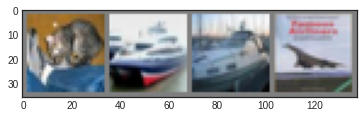

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver12().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

76.1


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 74.8%
Accuracy of car: 88.7%
Accuracy of bird: 60.8%
Accuracy of cat: 65.0%
Accuracy of deer: 74.0%
Accuracy of dog: 70.3%
Accuracy of frog: 75.4%
Accuracy of horse: 81.2%
Accuracy of ship: 86.7%
Accuracy of truck: 84.9%


# Ver.13 -> ver.6 개조 (+ fc layer / epoch 늘리기 10 -> 30)

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : o / weight_decay = 1e-4
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [ ]:
class Net_ver13(nn.Module) :

    def __init__(self) :

        super(Net_ver13, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Residual block

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        # Residual block

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 800 , bias = True)

        self.fc2 = nn.Linear(in_features = 800 , out_features = 200 , bias = True)

        self.fc3 = nn.Linear(in_features = 200 , out_features = 100 , bias = True)

        self.fc4 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = self.bn2(self.conv2(conv1_result))

      residual1_result = F.relu(conv1_result + conv2_result)

      maxpool_result = F.max_pool2d(residual1_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      residual2_result = F.relu(conv3_result + conv4_result)

      conv5_result = F.relu(self.bn5(self.conv5(residual2_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      residual3_result = F.relu(conv5_result + conv6_result)

      flatten_result = residual3_result.view(residual3_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc3_result = F.relu(self.fc3(fc2_result))

      fc3_result = self.dropout(fc2_result)

      fc4_result = self.fc3(fc3_result)

      return fc4_result

In [ ]:
myNet = Net_ver13().to(device) # gpu에 모델 저장

myNet

Net_ver13(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_feature

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 100])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                   [4, 800]       2,560,800
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9 , weight_decay = 1e-4)

## 모델 학습

In [ ]:
# epochs = 30

for epoch in range(30) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.084439150258899
Epoch: 1, Batch: 4000, Loss: 1.6986920482069254
Epoch: 1, Batch: 6000, Loss: 1.5173489117771388
Epoch: 1, Batch: 8000, Loss: 1.3778480430049822
Epoch: 1, Batch: 10000, Loss: 1.3394540640860797
Epoch: 1, Batch: 12000, Loss: 1.2433831019438804
Epoch: 2, Batch: 2000, Loss: 1.1112245291378349
Epoch: 2, Batch: 4000, Loss: 1.0584224124941974
Epoch: 2, Batch: 6000, Loss: 1.066056442665169
Epoch: 2, Batch: 8000, Loss: 1.0119890550242272
Epoch: 2, Batch: 10000, Loss: 0.976672271461226
Epoch: 2, Batch: 12000, Loss: 0.9520776900378988
Epoch: 3, Batch: 2000, Loss: 0.8542332459348254
Epoch: 3, Batch: 4000, Loss: 0.857573328992119
Epoch: 3, Batch: 6000, Loss: 0.8267526158681139
Epoch: 3, Batch: 8000, Loss: 0.8100915441009274
Epoch: 3, Batch: 10000, Loss: 0.7961336857283022
Epoch: 3, Batch: 12000, Loss: 0.7942055509528145
Epoch: 4, Batch: 2000, Loss: 0.6898713946422795
Epoch: 4, Batch: 4000, Loss: 0.6971645419482374
Epoch: 4, Batch: 6000, Loss: 0.6948637

## 모델의 저장 및 로드

In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver13().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

# Ver.14 -> ver.4 개조 (+ fc layer / epoch 늘리기 10 -> 15)

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 4
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : x / weight_decay = 1e-4
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [ ]:
class Net_ver14(nn.Module) :

    def __init__(self) :

        super(Net_ver14, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 800 , bias = True)

        self.fc2 = nn.Linear(in_features = 800 , out_features = 200 , bias = True)

        self.fc3 = nn.Linear(in_features = 200 , out_features = 100 , bias = True)

        self.fc4 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)


        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      maxpool_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      conv5_result = F.relu(self.bn5(self.conv5(conv4_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      flatten_result = conv6_result.view(conv6_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc3_result = self.dropout(F.relu(self.fc3(fc2_result)))

      fc4_result = self.fc4(fc3_result)

      return fc4_result

In [ ]:
myNet = Net_ver14().to(device) # gpu에 모델 저장

myNet

Net_ver14(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_feature

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                   [4, 800]       2,560,800
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9)

## 모델 학습

In [ ]:
# epochs = 15

for epoch in range(15) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.9775259949564934
Epoch: 1, Batch: 4000, Loss: 1.6775239775776862
Epoch: 1, Batch: 6000, Loss: 1.5311191792190075
Epoch: 1, Batch: 8000, Loss: 1.4242328273616731
Epoch: 1, Batch: 10000, Loss: 1.3191885201483964
Epoch: 1, Batch: 12000, Loss: 1.276267865344882
Epoch: 2, Batch: 2000, Loss: 1.1693384097106754
Epoch: 2, Batch: 4000, Loss: 1.1490324236582965
Epoch: 2, Batch: 6000, Loss: 1.0999895503036679
Epoch: 2, Batch: 8000, Loss: 1.0501087159067393
Epoch: 2, Batch: 10000, Loss: 1.0193155088187196
Epoch: 2, Batch: 12000, Loss: 0.9815772783216089
Epoch: 3, Batch: 2000, Loss: 0.9201302795861848
Epoch: 3, Batch: 4000, Loss: 0.904519767565187
Epoch: 3, Batch: 6000, Loss: 0.8714422957282514
Epoch: 3, Batch: 8000, Loss: 0.8926859464743174
Epoch: 3, Batch: 10000, Loss: 0.8489262711009942
Epoch: 3, Batch: 12000, Loss: 0.8424889456382952
Epoch: 4, Batch: 2000, Loss: 0.7694827008299034
Epoch: 4, Batch: 4000, Loss: 0.7976104271509684
Epoch: 4, Batch: 6000, Loss: 0.73534

## 모델의 저장 및 로드

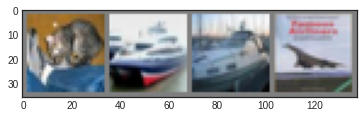

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver14().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

77.65


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 82.8%
Accuracy of car: 87.0%
Accuracy of bird: 65.4%
Accuracy of cat: 67.8%
Accuracy of deer: 71.7%
Accuracy of dog: 65.1%
Accuracy of frog: 80.0%
Accuracy of horse: 78.9%
Accuracy of ship: 85.0%
Accuracy of truck: 90.1%


# Ver.15 -> ver.4 개조 (kaiming_uniform_ initialization / epoch 10 -> 15)

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : x / weight_decay = 1e-4
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [ ]:
class Net_ver15(nn.Module) :

    def __init__(self) :

        super(Net_ver15, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 1000 , bias = True)
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')

        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100 , bias = True)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      maxpool_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      conv5_result = F.relu(self.bn5(self.conv5(conv4_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      flatten_result = conv6_result.view(conv6_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.fc3(fc2_result)

      return fc3_result

In [ ]:
myNet = Net_ver15().to(device) # gpu에 모델 저장

myNet

Net_ver15(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_feature

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                  [4, 1000]       3,201,000
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9)

## 모델 학습

In [ ]:
# epochs = 15

for epoch in range(15) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.150482193261385
Epoch: 1, Batch: 4000, Loss: 1.9535307171344758
Epoch: 1, Batch: 6000, Loss: 1.7941130655109883
Epoch: 1, Batch: 8000, Loss: 1.665542982250452
Epoch: 1, Batch: 10000, Loss: 1.549067727446556
Epoch: 1, Batch: 12000, Loss: 1.4635588532835244
Epoch: 2, Batch: 2000, Loss: 1.3284244307279587
Epoch: 2, Batch: 4000, Loss: 1.2871566390395164
Epoch: 2, Batch: 6000, Loss: 1.2165599801838398
Epoch: 2, Batch: 8000, Loss: 1.1950713954586536
Epoch: 2, Batch: 10000, Loss: 1.142292836273089
Epoch: 2, Batch: 12000, Loss: 1.1123823079690338
Epoch: 3, Batch: 2000, Loss: 1.04265664392896
Epoch: 3, Batch: 4000, Loss: 0.974619260225445
Epoch: 3, Batch: 6000, Loss: 0.977801145249512
Epoch: 3, Batch: 8000, Loss: 0.995592284576036
Epoch: 3, Batch: 10000, Loss: 0.9378504811548628
Epoch: 3, Batch: 12000, Loss: 0.9391277743063401
Epoch: 4, Batch: 2000, Loss: 0.8396542532534804
Epoch: 4, Batch: 4000, Loss: 0.8407260548322228
Epoch: 4, Batch: 6000, Loss: 0.833236725393

## 모델의 저장 및 로드

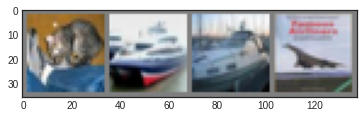

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver15().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

76.97


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 78.5%
Accuracy of car: 87.0%
Accuracy of bird: 70.1%
Accuracy of cat: 64.4%
Accuracy of deer: 69.2%
Accuracy of dog: 63.7%
Accuracy of frog: 78.3%
Accuracy of horse: 82.5%
Accuracy of ship: 86.6%
Accuracy of truck: 88.3%


# Ver.16 -> ver.4 개조 (softmax)

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : o / residual block : x / weight_decay = x
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [ ]:
class Net_ver16(nn.Module) :

    def __init__(self) :

        super(Net_ver16, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 1000 , bias = True)

        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100 , bias = True)

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

        self.softmax = nn.Softmax(dim = 0)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      maxpool_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      conv5_result = F.relu(self.bn5(self.conv5(conv4_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      flatten_result = conv6_result.view(conv6_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.softmax(self.fc3(fc2_result))

      return fc3_result

In [ ]:
myNet = Net_ver15().to(device) # gpu에 모델 저장

myNet

Net_ver15(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_feature

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                  [4, 1000]       3,201,000
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.1347140944302083
Epoch: 1, Batch: 4000, Loss: 1.8753621262907982
Epoch: 1, Batch: 6000, Loss: 1.7251052469164132
Epoch: 1, Batch: 8000, Loss: 1.6049764358848333
Epoch: 1, Batch: 10000, Loss: 1.4934444061145187
Epoch: 1, Batch: 12000, Loss: 1.417125646315515
Epoch: 2, Batch: 2000, Loss: 1.2824010709784925
Epoch: 2, Batch: 4000, Loss: 1.248071016356349
Epoch: 2, Batch: 6000, Loss: 1.1956408747589449
Epoch: 2, Batch: 8000, Loss: 1.1594999071881176
Epoch: 2, Batch: 10000, Loss: 1.0914353836593218
Epoch: 2, Batch: 12000, Loss: 1.0566738591054454
Epoch: 3, Batch: 2000, Loss: 0.9933390261465683
Epoch: 3, Batch: 4000, Loss: 0.9615574162418489
Epoch: 3, Batch: 6000, Loss: 0.9492660879734903
Epoch: 3, Batch: 8000, Loss: 0.918717892989982
Epoch: 3, Batch: 10000, Loss: 0.9226398812802509
Epoch: 3, Batch: 12000, Loss: 0.9002513348530047
Epoch: 4, Batch: 2000, Loss: 0.8232196274790913
Epoch: 4, Batch: 4000, Loss: 0.8033299388661981
Epoch: 4, Batch: 6000, Loss: 0.809973

## 모델의 저장 및 로드

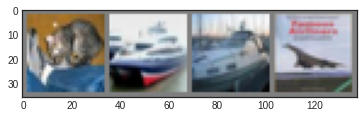

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver16().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

58.49


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 57.5%
Accuracy of car: 75.5%
Accuracy of bird: 46.2%
Accuracy of cat: 29.1%
Accuracy of deer: 57.2%
Accuracy of dog: 47.7%
Accuracy of frog: 67.9%
Accuracy of horse: 68.9%
Accuracy of ship: 67.0%
Accuracy of truck: 64.4%


# Ver.17 -> ver.4 개조 (optimizer : SGD -> Adagrad)

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : x / weight_decay = x
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD -> Adagrad

In [ ]:
class Net_ver17(nn.Module) :

    def __init__(self) :

        super(Net_ver17, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 1000 , bias = True)

        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100 , bias = True)

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      maxpool_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      conv5_result = F.relu(self.bn5(self.conv5(conv4_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      flatten_result = conv6_result.view(conv6_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.fc3(fc2_result)

      return fc3_result

In [ ]:
myNet = Net_ver17().to(device) # gpu에 모델 저장

myNet

Net_ver17(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_feature

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                  [4, 1000]       3,201,000
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adagrad(myNet.parameters(), lr = 0.01)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.1014784189462663
Epoch: 1, Batch: 4000, Loss: 1.7961905204057693
Epoch: 1, Batch: 6000, Loss: 1.6268732627034188
Epoch: 1, Batch: 8000, Loss: 1.5118913556039333
Epoch: 1, Batch: 10000, Loss: 1.4149876552671194
Epoch: 1, Batch: 12000, Loss: 1.3305082868859173
Epoch: 2, Batch: 2000, Loss: 1.2821955820694566
Epoch: 2, Batch: 4000, Loss: 1.2257574928700925
Epoch: 2, Batch: 6000, Loss: 1.1603107616044581
Epoch: 2, Batch: 8000, Loss: 1.141170386634767
Epoch: 2, Batch: 10000, Loss: 1.123050830900669
Epoch: 2, Batch: 12000, Loss: 1.0937626983616502
Epoch: 3, Batch: 2000, Loss: 1.0287103891968727
Epoch: 3, Batch: 4000, Loss: 1.0261907406728714
Epoch: 3, Batch: 6000, Loss: 1.0212531130872666
Epoch: 3, Batch: 8000, Loss: 0.9811521709747613
Epoch: 3, Batch: 10000, Loss: 0.9734686928987503
Epoch: 3, Batch: 12000, Loss: 0.9590031609442085
Epoch: 4, Batch: 2000, Loss: 0.8957468821229413
Epoch: 4, Batch: 4000, Loss: 0.9111525022927671
Epoch: 4, Batch: 6000, Loss: 0.87253

KeyboardInterrupt: ignored

## 모델의 저장 및 로드

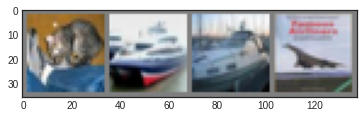

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver4().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

78.5


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 80.6%
Accuracy of car: 85.9%
Accuracy of bird: 71.3%
Accuracy of cat: 60.5%
Accuracy of deer: 70.5%
Accuracy of dog: 70.0%
Accuracy of frog: 81.5%
Accuracy of horse: 83.9%
Accuracy of ship: 88.8%
Accuracy of truck: 88.3%


# Ver.18 -> ver.4 개조 (SGD Momentum : 0.9 -> 0.95)

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : x / weight_decay = x
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [ ]:
class Net_ver18(nn.Module) :

    def __init__(self) :

        super(Net_ver18, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 1000 , bias = True)

        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100 , bias = True)

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      maxpool_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      conv5_result = F.relu(self.bn5(self.conv5(conv4_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      flatten_result = conv6_result.view(conv6_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.fc3(fc2_result)

      return fc3_result

In [ ]:
myNet = Net_ver18().to(device) # gpu에 모델 저장

myNet

Net_ver18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_feature

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                  [4, 1000]       3,201,000
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.95)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.9907273701131343
Epoch: 1, Batch: 4000, Loss: 1.7602523234188556
Epoch: 1, Batch: 6000, Loss: 1.6089075766652823
Epoch: 1, Batch: 8000, Loss: 1.5147135928347706
Epoch: 1, Batch: 10000, Loss: 1.4099064242988826
Epoch: 1, Batch: 12000, Loss: 1.3086514218132943
Epoch: 2, Batch: 2000, Loss: 1.204059905167669
Epoch: 2, Batch: 4000, Loss: 1.1714655393622815
Epoch: 2, Batch: 6000, Loss: 1.118545487712603
Epoch: 2, Batch: 8000, Loss: 1.0831722470673266
Epoch: 2, Batch: 10000, Loss: 1.0452845003837719
Epoch: 2, Batch: 12000, Loss: 1.026745431485586
Epoch: 3, Batch: 2000, Loss: 0.9281204895873089
Epoch: 3, Batch: 4000, Loss: 0.9224792145914398
Epoch: 3, Batch: 6000, Loss: 0.8886848408938386
Epoch: 3, Batch: 8000, Loss: 0.8839729760203044
Epoch: 3, Batch: 10000, Loss: 0.8545217518871651
Epoch: 3, Batch: 12000, Loss: 0.864652726801578
Epoch: 4, Batch: 2000, Loss: 0.775012233071262
Epoch: 4, Batch: 4000, Loss: 0.769915815101267
Epoch: 4, Batch: 6000, Loss: 0.780412570

## 모델의 저장 및 로드

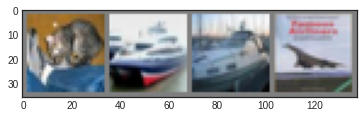

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver18().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

77.07


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 75.2%
Accuracy of car: 89.6%
Accuracy of bird: 65.6%
Accuracy of cat: 55.9%
Accuracy of deer: 77.6%
Accuracy of dog: 72.0%
Accuracy of frog: 81.6%
Accuracy of horse: 79.0%
Accuracy of ship: 88.8%
Accuracy of truck: 83.6%


# Ver.19 -> ver.4 개조 (초반에 kernel_size 줄이기)

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : x / weight_decay = x
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [ ]:
class Net_ver19(nn.Module) :

    def __init__(self) :

        super(Net_ver19, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 2 , padding = 1)
        # (32 - 2 + 2)/1 + 1 = 33
        # 4 * 64 * 33 * 33

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 2 , padding = 1)
        # (33 - 2 + 2)/1 + 1 = 34
        # 4 * 64 * 34 * 34

        self.bn2 = BatchNorm2d(64)

        # Maxpool : 34 -> 17

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (17 - 3 + 0)/1 + 1 = 15
        # 4 * 96 * 15 * 15 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 64 , kernel_size = 5)
        # (15 - 5 + 0)/1 + 1 = 11
        # 4 * 96 * 11 * 11

        self.bn4 = BatchNorm2d(64)

        self.conv5 = nn.Conv2d(in_channels = 64 , out_channels = 32 , kernel_size = 5)
        # (11 - 5 + 0)/1 + 1 = 7
        # 4 * 32 * 7 * 7

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (7 - 3 + 2)/1 + 1 = 7
        # 4 * 32 * 7 * 7

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 1568 , out_features = 500 , bias = True)

        self.fc2 = nn.Linear(in_features = 500 , out_features = 100 , bias = True)

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      maxpool_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      conv5_result = F.relu(self.bn5(self.conv5(conv4_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      flatten_result = conv6_result.view(conv6_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.fc3(fc2_result)

      return fc3_result

In [ ]:
myNet = Net_ver19().to(device) # gpu에 모델 저장

myNet

Net_ver19(
  (conv1): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_feat

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 33, 33]             832
       BatchNorm2d-2            [4, 64, 33, 33]             128
            Conv2d-3            [4, 64, 34, 34]          16,448
       BatchNorm2d-4            [4, 64, 34, 34]             128
            Conv2d-5            [4, 96, 15, 15]          55,392
       BatchNorm2d-6            [4, 96, 15, 15]             192
            Conv2d-7            [4, 64, 11, 11]         153,664
       BatchNorm2d-8            [4, 64, 11, 11]             128
            Conv2d-9              [4, 32, 7, 7]          51,232
      BatchNorm2d-10              [4, 32, 7, 7]              64
           Conv2d-11              [4, 32, 7, 7]           9,248
      BatchNorm2d-12              [4, 32, 7, 7]              64
           Linear-13                   [4, 500]         784,500
           Linear-14                   

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9)

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.0255252731740474
Epoch: 1, Batch: 4000, Loss: 1.7470760606229305
Epoch: 1, Batch: 6000, Loss: 1.591171575218439
Epoch: 1, Batch: 8000, Loss: 1.4744637647271157
Epoch: 1, Batch: 10000, Loss: 1.4036893968097865
Epoch: 1, Batch: 12000, Loss: 1.3255954036191107
Epoch: 2, Batch: 2000, Loss: 1.2395802791006862
Epoch: 2, Batch: 4000, Loss: 1.214564531929791
Epoch: 2, Batch: 6000, Loss: 1.1836998906210066
Epoch: 2, Batch: 8000, Loss: 1.1221155305597932
Epoch: 2, Batch: 10000, Loss: 1.0942111734808422
Epoch: 2, Batch: 12000, Loss: 1.0698377131065353
Epoch: 3, Batch: 2000, Loss: 1.0231445944523438
Epoch: 3, Batch: 4000, Loss: 1.0017744763814844
Epoch: 3, Batch: 6000, Loss: 0.977231075393036
Epoch: 3, Batch: 8000, Loss: 0.948158453160082
Epoch: 3, Batch: 10000, Loss: 0.973431727070827
Epoch: 3, Batch: 12000, Loss: 0.9417559929192066
Epoch: 4, Batch: 2000, Loss: 0.8837014878629706
Epoch: 4, Batch: 4000, Loss: 0.861114699547179
Epoch: 4, Batch: 6000, Loss: 0.865966247

## 모델의 저장 및 로드

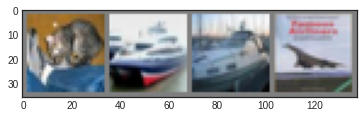

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net_ver19().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

75.09


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 72.8%
Accuracy of car: 91.5%
Accuracy of bird: 65.5%
Accuracy of cat: 56.4%
Accuracy of deer: 81.6%
Accuracy of dog: 56.9%
Accuracy of frog: 86.0%
Accuracy of horse: 72.3%
Accuracy of ship: 87.6%
Accuracy of truck: 82.5%


# Ver.4 Again -> image auqmentation

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : x / weight_decay = x
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [31]:
class Net_ver4(nn.Module) :

    def __init__(self) :

        super(Net_ver4, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32

        self.bn2 = BatchNorm2d(64)

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels = 96 , kernel_size = 3)
        # (16 - 3 + 0)/1 + 12 = 14
        # 4 * 96 * 14 * 14 

        self.bn3 = BatchNorm2d(96)

        self.conv4 = nn.Conv2d(in_channels = 96 , out_channels = 96 , kernel_size = 3 , padding = 1)
        # (14 - 3 + 2)/1 + 1 = 14
        # 4 * 96 * 14 * 14

        self.bn4 = BatchNorm2d(96)

        self.conv5 = nn.Conv2d(in_channels = 96 , out_channels = 32 , kernel_size = 5)
        # (14 - 5 + 0)/1 + 1 = 10
        # 4 * 32 * 10 * 10 

        self.bn5 = BatchNorm2d(32)

        self.conv6 = nn.Conv2d(in_channels = 32 , out_channels = 32 , kernel_size = 3 , padding = 1)
        # (10 - 3 + 2)/1 + 1 = 10
        # 4 * 32 * 10 * 10

        self.bn6 = BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features = 3200 , out_features = 1000 , bias = True)

        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100 , bias = True)

        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      maxpool_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool_result)))
       
      conv4_result = F.relu(self.bn4(self.conv4(conv3_result)))

      conv5_result = F.relu(self.bn5(self.conv5(conv4_result)))

      conv6_result = F.relu(self.bn6(self.conv6(conv5_result)))

      flatten_result = conv6_result.view(conv6_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      fc2_result = F.relu(self.fc2(fc1_result))

      fc2_result = self.dropout(fc2_result)

      fc3_result = self.fc3(fc2_result)

      return fc3_result

In [32]:
myNet = Net_ver4().to(device) # gpu에 모델 저장

myNet

Net_ver4(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features

In [33]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [34]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [35]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
            Conv2d-5            [4, 96, 14, 14]          55,392
       BatchNorm2d-6            [4, 96, 14, 14]             192
            Conv2d-7            [4, 96, 14, 14]          83,040
       BatchNorm2d-8            [4, 96, 14, 14]             192
            Conv2d-9            [4, 32, 10, 10]          76,832
      BatchNorm2d-10            [4, 32, 10, 10]              64
           Conv2d-11            [4, 32, 10, 10]           9,248
      BatchNorm2d-12            [4, 32, 10, 10]              64
           Linear-13                  [4, 1000]       3,201,000
           Linear-14                   

## 손실함수와 옵티마이저

In [36]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9)

## 모델 학습

In [37]:
# epochs = 10

for epoch in range(10) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.0143162723481653
Epoch: 1, Batch: 4000, Loss: 1.8071152190566062
Epoch: 1, Batch: 6000, Loss: 1.680783806860447
Epoch: 1, Batch: 8000, Loss: 1.5576035729348658
Epoch: 1, Batch: 10000, Loss: 1.497775508016348
Epoch: 1, Batch: 12000, Loss: 1.3940455857291818
Epoch: 2, Batch: 2000, Loss: 1.3406212700381874
Epoch: 2, Batch: 4000, Loss: 1.3113987715132533
Epoch: 2, Batch: 6000, Loss: 1.2641761453673244
Epoch: 2, Batch: 8000, Loss: 1.19278024828434
Epoch: 2, Batch: 10000, Loss: 1.2085162485595793
Epoch: 2, Batch: 12000, Loss: 1.154109590396285
Epoch: 3, Batch: 2000, Loss: 1.1261082174703478
Epoch: 3, Batch: 4000, Loss: 1.0701974436137824
Epoch: 3, Batch: 6000, Loss: 1.0529007756765931
Epoch: 3, Batch: 8000, Loss: 1.060717445788905
Epoch: 3, Batch: 10000, Loss: 1.024032095069997
Epoch: 3, Batch: 12000, Loss: 1.0371801240369678
Epoch: 4, Batch: 2000, Loss: 0.954361198047176
Epoch: 4, Batch: 4000, Loss: 0.9752612862931564
Epoch: 4, Batch: 6000, Loss: 0.95367418364

## 모델의 저장 및 로드

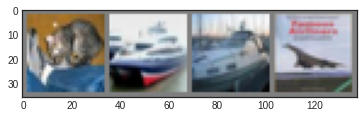

	cat 	ship 	ship 	plane


In [38]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [39]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [42]:
# 불러오기

Loaded_Net = Net_ver4().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [43]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

80.52


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [44]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 90.9%
Accuracy of car: 89.9%
Accuracy of bird: 66.4%
Accuracy of cat: 70.5%
Accuracy of deer: 82.9%
Accuracy of dog: 65.6%
Accuracy of frog: 85.4%
Accuracy of horse: 76.6%
Accuracy of ship: 85.7%
Accuracy of truck: 90.2%


# Ver.20 (image auqmentation)

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

* Layer : conv : 6 / Maxpool : 1 / fc : 3
* 채널 수 줄이기, padding 줄이기
* Bn : o / Dropout : 1개만 / softmax : x / residual block : x / weight_decay = x
* 적은 channel에서 kernel_size 늘리기
* 최대 out_channels = 96 + Adam -> SGD

In [53]:
class Net_ver20(nn.Module) :

    def __init__(self) :

        super(Net_ver20, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 64 * 32 * 32 

        self.bn1 = BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 128 , kernel_size = 3 , padding = 1)
        # (32 - 3 + 2)/1 + 1 = 32
        # 4 * 128 * 32 * 32

        self.bn2 = BatchNorm2d(128)

        # Maxpool : 32 -> 16

        self.conv3 = nn.Conv2d(in_channels = 128 , out_channels = 128 , kernel_size = 3 , padding = 1)
        # (16 - 3 + 2)/1 + 1 = 16
        # 4 * 128 * 16 * 16 

        self.bn3 = BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels = 128 , out_channels = 128 , kernel_size = 3 , padding = 1)
        # (16 - 3 + 2)/1 + 1 = 16
        # 4 * 128 * 16 * 16

        self.bn4 = BatchNorm2d(128)

        # residual block

        self.conv5 = nn.Conv2d(in_channels = 128 , out_channels = 256 , kernel_size = 3 , padding = 1)
        # (16 - 5 + 0)/1 + 1 = 16
        # 4 * 32 * 16 * 16 

        self.bn5 = BatchNorm2d(256)

        # Maxpool : 16 -> 8

        self.conv6 = nn.Conv2d(in_channels = 256 , out_channels = 512 , kernel_size = 3 , padding = 1)
        # (8 - 3 + 2)/1 + 1 = 8
        # 4 * 256 * 8 * 8

        self.bn6 = BatchNorm2d(512)

        # Maxpool : 8 -> 4

        self.conv7 = nn.Conv2d(in_channels = 512 , out_channels = 512 , kernel_size = 3 , padding = 1)
        # (4 - 3 + 2)/1 + 1 = 4
        # 4 * 512 * 4 * 4 

        self.bn7 = BatchNorm2d(512)

        self.conv8 = nn.Conv2d(in_channels = 512 , out_channels = 512 , kernel_size = 3 , padding = 1)
        # (4 - 3 + 2)/1 + 1 = 4
        # 4 * 512 * 4 * 4

        self.bn8 = BatchNorm2d(512)

        # residual block

        # Maxpool : 4 -> 1     

        self.fc1 = nn.Linear(in_features = 512 , out_features = 10 , bias = True)

        self.dropout = nn.Dropout(p = 0.5, inplace = False)

    def forward(self, x) : 

      conv1_result = F.relu(self.bn1(self.conv1(x)))
       
      conv2_result = F.relu(self.bn2(self.conv2(conv1_result)))

      maxpool1_result = F.max_pool2d(conv2_result, (2,2))

      conv3_result = F.relu(self.bn3(self.conv3(maxpool1_result)))
       
      conv4_result = self.bn4(self.conv4(conv3_result))

      residual1_block = F.relu(conv3_result + conv4_result)

      conv5_result = F.relu(self.bn5(self.conv5(residual1_block)))

      maxpool2_result = F.max_pool2d(conv5_result , (2,2))

      conv6_result = F.relu(self.bn6(self.conv6(maxpool2_result)))

      maxpool3_result = F.max_pool2d(conv6_result , (2,2))

      conv7_result = F.relu(self.bn7(self.conv7(maxpool3_result)))
       
      conv8_result = self.bn8(self.conv8(conv7_result))

      residual2_block = F.relu(conv7_result + conv8_result)

      maxpool4_result = F.max_pool2d(residual2_block , 4)

      flatten_result = maxpool4_result.view(maxpool4_result.size(0), -1)

      fc1_result = F.relu(self.fc1(flatten_result))

      return fc1_result

In [54]:
myNet = Net_ver20().to(device) # gpu에 모델 저장

myNet

Net_ver20(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_

In [55]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)

input.size()

torch.Size([4, 3, 32, 32])

In [56]:
# output; (4 * 10)

output = myNet.forward(input)

output.size()

torch.Size([4, 10])

In [57]:
# 모델 구조 확인

summary(myNet, input_size=(3 , 32 , 32), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3           [4, 128, 32, 32]          73,856
       BatchNorm2d-4           [4, 128, 32, 32]             256
            Conv2d-5           [4, 128, 16, 16]         147,584
       BatchNorm2d-6           [4, 128, 16, 16]             256
            Conv2d-7           [4, 128, 16, 16]         147,584
       BatchNorm2d-8           [4, 128, 16, 16]             256
            Conv2d-9           [4, 256, 16, 16]         295,168
      BatchNorm2d-10           [4, 256, 16, 16]             512
           Conv2d-11             [4, 512, 8, 8]       1,180,160
      BatchNorm2d-12             [4, 512, 8, 8]           1,024
           Conv2d-13             [4, 512, 4, 4]       2,359,808
      BatchNorm2d-14             [4, 51

## 손실함수와 옵티마이저

In [62]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(myNet.parameters(), lr = 0.01, betas = (0.9 , 0.999) , weight_decay = 1e-4)

## 모델 학습

In [63]:
# epochs = 15

for epoch in range(15) :

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화

        outputs = myNet(inputs)           # y_pred
        loss = criterion(outputs, labels) # 손실함수를 이용해서 loss계산
        loss.backward()                   # back-propagation
        optimizer.step()                  # 가중치 업데이트

        running_loss += loss.item()

        if i % 2000 == 1999 :

            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))

            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.304418548345566
Epoch: 1, Batch: 4000, Loss: 2.3025851249694824
Epoch: 1, Batch: 6000, Loss: 2.302646492123604
Epoch: 1, Batch: 8000, Loss: 2.302587982416153
Epoch: 1, Batch: 10000, Loss: 2.302671203613281
Epoch: 1, Batch: 12000, Loss: 2.302726846575737
Epoch: 2, Batch: 2000, Loss: 2.302668634414673
Epoch: 2, Batch: 4000, Loss: 2.302659496545792
Epoch: 2, Batch: 6000, Loss: 2.302585127353668
Epoch: 2, Batch: 8000, Loss: 2.3029470765590667
Epoch: 2, Batch: 10000, Loss: 2.3035676329135897
Epoch: 2, Batch: 12000, Loss: 2.3026016294956206
Epoch: 3, Batch: 2000, Loss: 2.302551191449165
Epoch: 3, Batch: 4000, Loss: 2.3027239196300506
Epoch: 3, Batch: 6000, Loss: 2.3026209470033647
Epoch: 3, Batch: 8000, Loss: 2.3026232763528824
Epoch: 3, Batch: 10000, Loss: 2.3036275886297224
Epoch: 3, Batch: 12000, Loss: 2.3027348724603653
Epoch: 4, Batch: 2000, Loss: 2.3025851249694824
Epoch: 4, Batch: 4000, Loss: 2.3025851249694824
Epoch: 4, Batch: 6000, Loss: 2.303421236634

## 모델의 저장 및 로드

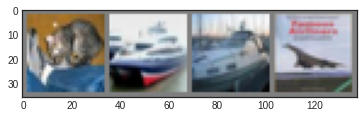

	cat 	ship 	ship 	plane


In [64]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [65]:
# 저장

PATH = '/cifar-10.pth'
torch.save(myNet.state_dict(), PATH)

In [66]:
# 불러오기

Loaded_Net = Net_ver20().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [67]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad() :

    for data in test_loader :
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)          # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0)                                 # 전체 갯수
        correct += (predicted == labels).sum().item()           # 맞춘 갯수
    
    print(100 * correct / total)

10.0


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [68]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 100.0%
Accuracy of car: 0.0%
Accuracy of bird: 0.0%
Accuracy of cat: 0.0%
Accuracy of deer: 0.0%
Accuracy of dog: 0.0%
Accuracy of frog: 0.0%
Accuracy of horse: 0.0%
Accuracy of ship: 0.0%
Accuracy of truck: 0.0%
